# Introduction

Exploration of structured data and labels

**Authors**
- Eric Carlson

In [1]:
structured_collection_date = '2016-10-24-16-35'

In [2]:
from datetime import datetime
import configparser
import hashlib
from importlib import reload
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib as pl
import pickle as pkl
import sklearn as sk
from sklearn import linear_model, metrics, model_selection
import sys
import yaml

from IPython import display

import etc_utils as eu
import mimic_extraction_utils as meu
import structured_data_utils as sdu

In [3]:
np.random.seed(12345)

In [4]:
reload(eu)
reload(meu)
reload(sdu)

<module 'structured_data_utils' from '/Users/ecarlson/code/etc/ektar-pelican/content/notebooks/mit_freq_fliers/structured_data_utils.py'>

In [6]:
sys.path.append('icd9')
from icd9 import ICD9

# feel free to replace with your path to the json file
tree = ICD9('icd9/codes.json')

## Configure pandas and matplot lib for nice web printing

In [7]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

In [8]:
%matplotlib inline

## Load config files, configure logging

In [9]:
work_desc = "gather_structured_data"

In [10]:
time_str, path_config, creds = eu.load_config_v2(creds_file='../../private/mit_freq_fliers/credentials.yaml')
print('Time string: {}'.format(time_str))

print('Paths:')
for k, item in path_config.items():
    print('{}: {}'.format(k, item))

Time string: 2016-12-31-12-52
Paths:
log_dir: /Users/ecarlson/logs/mit_frequent_fliers
input_dir: /Users/ecarlson/data/mit_frequent_fliers
results_dir: /Users/ecarlson/results/mit_frequent_fliers
repo_data_dir: /Users/ecarlson/code/etc/mit_frequent_fliers/mit-team-code/data


In [11]:
logger = logging.getLogger()

eu.configure_logging(logger, work_desc=work_desc, log_directory=path_config['log_dir'], time_str=time_str)

Logging to /Users/ecarlson/logs/mit_frequent_fliers/2016-12-31-12-52_gather_structured_data.log


In [12]:
[k for k in creds.keys()]

['postgres', 'mimic3_v1_4', 'mimic2_v2_6']

# Load labeled notes

In [13]:
categories = ['Advanced.Cancer', 'Advanced.Heart.Disease', 'Advanced.Lung.Disease',
       'Alcohol.Abuse',
       'Chronic.Neurological.Dystrophies', 'Chronic.Pain.Fibromyalgia',
       'Dementia', 'Depression', 'Developmental.Delay.Retardation',
       'Non.Adherence', 'None',
       'Obesity', 'Other.Substance.Abuse', 
       'Schizophrenia.and.other.Psychiatric.Disorders', 'Unsure',]

In [14]:
data_path = pl.Path(path_config['repo_data_dir'])

In [16]:
[p for p in data_path.glob('*{}*csv'.format(structured_collection_date))]

[PosixPath('/Users/ecarlson/code/etc/mit_frequent_fliers/mit-team-code/data/combined_label_data_2016-10-24-16-35.csv'),
 PosixPath('/Users/ecarlson/code/etc/mit_frequent_fliers/mit-team-code/data/mimic3_note_metadata_2016-10-24-16-35.csv'),
 PosixPath('/Users/ecarlson/code/etc/mit_frequent_fliers/mit-team-code/data/notes_icd9_codes_2016-10-24-16-35.csv')]

In [17]:
labels_path = data_path.joinpath('combined_label_data_{}.csv'.format(structured_collection_date))
note_meta_path = data_path.joinpath('mimic3_note_metadata_{}.csv'.format(structured_collection_date))
note_icd9_path = data_path.joinpath('notes_icd9_codes_{}.csv'.format(structured_collection_date))

In [18]:
labels_df = pd.read_csv(labels_path.as_posix())
note_meta_df = pd.read_csv(note_meta_path.as_posix())
note_icd9_df = pd.read_csv(note_icd9_path.as_posix())

In [19]:
labels_df.head()

,subject_id,category,md5,operator,Advanced.Cancer,Advanced.Heart.Disease,Advanced.Lung.Disease,Alcohol.Abuse,Chronic.Neurological.Dystrophies,Chronic.Pain.Fibromyalgia,Dementia,Depression,Developmental.Delay.Retardation,Non.Adherence,None,Obesity,Other.Substance.Abuse,Schizophrenia.and.other.Psychiatric.Disorders,Unsure,row_id_m3,total_m3_distance
0,9973,Discharge,56f2598342cce321539d8975809d487c,JTW,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,NaN,NaN
1,9973,Discharge,56f2598342cce321539d8975809d487c,ETM,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,NaN,NaN
2,3365,Discharge,eaea5c3c7577135a83f1f0fb583e0d53,JTW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17170.0,0.000884
3,3365,Discharge,eaea5c3c7577135a83f1f0fb583e0d53,ETM,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17170.0,0.000884
4,27290,Discharge,e7433c0b75ea00346390f029bb830774,JW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,50828.0,0.001554


In [20]:
labels_df.shape

(3838, 21)

In [21]:
note_meta_df.head()

,cgid,chartdate,charttime,hadm_id,md5,note_row_id,storetime,subject_id
0,17770.0,2154-06-03 00:00:00,2154-06-03 17:30:00,172993.0,be74552c73a0f9895c4f372763054d26,1414073.0,2154-06-03 17:51:00,11590
1,17698.0,2183-07-28 00:00:00,2183-07-28 05:41:00,116105.0,2bd0c96855c6107be79d0150e1f121e7,1449706.0,2183-07-28 05:53:00,14342
2,NaN,2170-02-13 00:00:00,NaN,122710.0,bd4bf8040238e3e2cdd7466692defe73,47105.0,NaN,8217
3,18469.0,2175-06-07 00:00:00,2175-06-07 05:39:00,196691.0,6d20d9b6d3cfdc3fc9e8a72fbab0f697,1573953.0,2175-06-07 06:27:00,23829
4,17079.0,2125-04-27 00:00:00,2125-04-27 20:51:00,133059.0,d35003faa86241e60396014264b14a4d,1264491.0,2125-04-27 21:03:00,305


In [22]:
note_icd9_df.head()

,code,level,md5,note_row_id,subject_id
0,41071,source,be74552c73a0f9895c4f372763054d26,1414073.0,11590
1,39891,source,be74552c73a0f9895c4f372763054d26,1414073.0,11590
2,390-459,0,be74552c73a0f9895c4f372763054d26,1414073.0,11590
3,393-398,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590
4,398,2,be74552c73a0f9895c4f372763054d26,1414073.0,11590


# Inspect data

In [23]:
note_icd9_df.shape

(89273, 5)

In [24]:
note_icd9_df.query('level == "source"').shape

(21044, 5)

In [25]:
grouped = note_icd9_df.query('level == "source"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

code
4280     690
4019     570
42731    499
5849     386
41401    347
Name: md5, dtype: int64

(1852,)


In [26]:
grouped = note_icd9_df.query('level == "0"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

code
390-459    4213
460-519    1825
240-279    1801
580-629    1349
520-579    1223
Name: md5, dtype: int64

(41,)


In [27]:
grouped = note_icd9_df.query('level == "1"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

code
420-429    2085
270-279    1320
510-519     937
580-589     833
996-999     699
Name: md5, dtype: int64

(181,)


In [28]:
grouped = note_icd9_df.query('level == "2"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

code
428    992
276    788
427    755
518    618
401    583
Name: md5, dtype: int64

(632,)


In [29]:
grouped = note_icd9_df.query('level == "3"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

code
428.0    690
401.9    570
427.3    546
518.8    505
414.0    408
Name: md5, dtype: int64

(1017,)


In [30]:
grouped = note_icd9_df.query('level == "4"').groupby('code').count().sort_values('md5', ascending=False)['md5']
display.display(grouped.head())
print(grouped.shape)

Series([], Name: md5, dtype: int64)

(0,)


From above, see that there are no "level 4" codes.  As we increase from level 0 to level 3 we get more specific codes, with corresponding increase in number of codes and decrease in the maximum frequency of occurence.  

# Assemble data for classification

## As a first pass, start with a single diagnosis level, combine with labels, inspect

In [27]:
icd9_1lev = note_icd9_df.query('level == "1"')
icd9_1lev.head()

,code,level,md5,note_row_id,subject_id
3,393-398,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590
8,393-398,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590
13,393-398,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590
18,042,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590
22,510-519,1,be74552c73a0f9895c4f372763054d26,1414073.0,11590


In [28]:
labels_df.head()

,subject_id,category,md5,operator,Advanced.Cancer,Advanced.Heart.Disease,Advanced.Lung.Disease,Alcohol.Abuse,Chronic.Neurological.Dystrophies,Chronic.Pain.Fibromyalgia,Dementia,Depression,Developmental.Delay.Retardation,Non.Adherence,None,Obesity,Other.Substance.Abuse,Schizophrenia.and.other.Psychiatric.Disorders,Unsure,row_id_m3,total_m3_distance
0,9973,Discharge,56f2598342cce321539d8975809d487c,JTW,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,NaN,NaN
1,9973,Discharge,56f2598342cce321539d8975809d487c,ETM,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,NaN,NaN
2,3365,Discharge,eaea5c3c7577135a83f1f0fb583e0d53,JTW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17170.0,0.000884
3,3365,Discharge,eaea5c3c7577135a83f1f0fb583e0d53,ETM,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17170.0,0.000884
4,27290,Discharge,e7433c0b75ea00346390f029bb830774,JW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,50828.0,0.001554


In [29]:
tmp_df = icd9_1lev.groupby(['subject_id', 'md5', 'code']).agg({'level': lambda x: 1})
tmp_df.rename(columns={'level': 'code'}, inplace=True)
icd9_vec_df = tmp_df.unstack(fill_value=0)
#icd9_vec_df.columns = icd9_vec_df.columns.droplevel()

In [30]:
icd9_vec_df.head()

code                          \
code                                        001-009 030-041 042 047 050-059   
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16       0       0   1   0       0   
109        27d1f5907fa14b6702837a845f84c54e       0       0   0   0       0   
           3e0fff775cfb678fdfa06ece68ebfab5       0       0   0   0       0   
           8efc0a2ff698b75ce183e3183c1bf204       0       0   0   0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db       0       0   0   0       0   

                                                                         \
code                                        062 070-079 110-118 120-129   
subject_id md5                                                            
68         27572b36bd4c26c322f50cf65d095d16   0       0       0       0   
109        27d1f5907fa14b6702837a845f84c54e   0       0       1       0   
           3e0fff775cfb678fdfa06ece68ebfab5   0       0       0       0   
           8efc0a2ff698b75ce183e3183c1bf204   0       0       0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db   0       0       0       0   

                                                                             \
code                                        130-136 137-139 140-149 150-159   
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16       0       0       0       0   
109        27d1f5907fa14b6702837a845f84c54e       0       0       0       0   
           3e0fff775cfb678fdfa06ece68ebfab5       0       0       0       0   
           8efc0a2ff698b75ce183e3183c1bf204       0       0       0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db       0       0       0       0   

                                                                             \
code                                        160-165 170-176 179-189 190-199   
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16       0       0       0       0   
109        27d1f5907fa14b6702837a845f84c54e       0       0       0       0   
           3e0fff775cfb678fdfa06ece68ebfab5       0       0       0       0   
           8efc0a2ff698b75ce183e3183c1bf204       0       0       0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db       0       0       0       0   

                                                                         \
code                                        210-229 235-238 239 240-246   
subject_id md5                                                            
68         27572b36bd4c26c322f50cf65d095d16       0       0   0       0   
109        27d1f5907fa14b6702837a845f84c54e       0       0   0       0   
           3e0fff775cfb678fdfa06ece68ebfab5       0       0   0       0   
           8efc0a2ff698b75ce183e3183c1bf204       0       0   0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db       0       0   0       0   

                                                                             \
code                                        249-259 260-269 270-279 290-299   
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16       0       1       1       0   
109        27d1f5907fa14b6702837a845f84c54e       0       0       0       0   
           3e0fff775cfb678fdfa06ece68ebfab5       0       0       0       0   
           8efc0a2ff698b75ce183e3183c1bf204       0       0       0       0   
           f5f69772c32f1b0ac05b7cf408f7a6db       0       0       0       0   

                                            ...                              \
code                                        ... V18 V26 V42 V43 V44 V45 V46   
subject_id md5                              ...                               
68         27572b36bd4c26c322f50cf65d095d16 ...   0   0   0   0   0   0   0 

In [125]:
feat_vecs = labels_df.groupby(['subject_id', 'md5']).max()[['category',] + categories]
feat_vecs = feat_vecs.join(icd9_vec_df)

/mnt/cbds_homes/ecarlson/.local/lib/python3.4/site-packages/pandas/tools/merge.py:480: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [126]:
feat_vecs.head()

category  Advanced.Cancer  \
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16  Nursing/Other                0   
109        27d1f5907fa14b6702837a845f84c54e  Nursing/Other                0   
           3e0fff775cfb678fdfa06ece68ebfab5  Nursing/Other                0   
           8efc0a2ff698b75ce183e3183c1bf204  Nursing/Other                0   
           f5f69772c32f1b0ac05b7cf408f7a6db      Discharge                0   

                                             Advanced.Heart.Disease  \
subject_id md5                                                        
68         27572b36bd4c26c322f50cf65d095d16                       0   
109        27d1f5907fa14b6702837a845f84c54e                       0   
           3e0fff775cfb678fdfa06ece68ebfab5                       1   
           8efc0a2ff698b75ce183e3183c1bf204                       0   
           f5f69772c32f1b0ac05b7cf408f7a6db                       0   

                                             Advanced.Lung.Disease  \
subject_id md5                                                       
68         27572b36bd4c26c322f50cf65d095d16                      0   
109        27d1f5907fa14b6702837a845f84c54e                      0   
           3e0fff775cfb678fdfa06ece68ebfab5                      0   
           8efc0a2ff698b75ce183e3183c1bf204                      0   
           f5f69772c32f1b0ac05b7cf408f7a6db                      0   

                                             Alcohol.Abuse  \
subject_id md5                                               
68         27572b36bd4c26c322f50cf65d095d16              0   
109        27d1f5907fa14b6702837a845f84c54e              0   
           3e0fff775cfb678fdfa06ece68ebfab5              0   
           8efc0a2ff698b75ce183e3183c1bf204              0   
           f5f69772c32f1b0ac05b7cf408f7a6db              0   

                                             Chronic.Neurological.Dystrophies  \
subject_id md5                                                                  
68         27572b36bd4c26c322f50cf65d095d16                                 0   
109        27d1f5907fa14b6702837a845f84c54e                                 0   
           3e0fff775cfb678fdfa06ece68ebfab5                                 0   
           8efc0a2ff698b75ce183e3183c1bf204                                 0   
           f5f69772c32f1b0ac05b7cf408f7a6db                                 0   

                                             Chronic.Pain.Fibromyalgia  \
subject_id md5                                                           
68         27572b36bd4c26c322f50cf65d095d16                          0   
109        27d1f5907fa14b6702837a845f84c54e                          1   
           3e0fff775cfb678fdfa06ece68ebfab5                          0   
           8efc0a2ff698b75ce183e3183c1bf204                          0   
           f5f69772c32f1b0ac05b7cf408f7a6db                          0   

                                             Dementia  Depression  \
subject_id md5                                                      
68         27572b36bd4c26c322f50cf65d095d16         0           0   
109        27d1f5907fa14b6702837a845f84c54e         0           0   
           3e0fff775cfb678fdfa06ece68ebfab5         0           0   
           8efc0a2ff698b75ce183e3183c1bf204         0           0   
           f5f69772c32f1b0ac05b7cf408f7a6db         0           0   

                                             Developmental.Delay.Retardation  \
subject_id md5                                                                 
68         27572b36bd4c26c322f50cf65d095d16                                0   
109        27d1f5907fa14b6702837a845f84c54e                                0   
           3e0fff775cfb678fdfa06ece68ebfab5                                0   
           8efc0a2ff698b75ce183e3183c1bf204                                0   
           f5f69772c3

In [132]:
feat_vecs.shape

(1849, 197)

In [127]:
feature_cols = [c for c in feat_vecs.columns if isinstance(c, tuple)]

In [128]:
code_lookup = [{'icd9':icd, 'descr': tree.find(icd[1]).description} for icd in feature_cols]

In [129]:
code_lookup_df = pd.DataFrame(code_lookup).set_index('icd9')

Note: not really an odds ratio, dividing by population mean rather than mean of non-flagged population, otherwise many divide by zeros

In [130]:
all_vecs = feat_vecs[feature_cols].mean()
likely_concepts = dict()
for cat in categories:
    with_label = feat_vecs.loc[feat_vecs[cat]==1, feature_cols].mean()
    with_label = with_label/all_vecs
#     no_label = feat_vecs.loc[feat_vecs[cat]==0, feature_cols].mean()
#     with_label = with_label/no_label
    with_label.name = 'OR'
    with_label = code_lookup_df.join(pd.DataFrame(with_label))
    likely_concepts[cat] = with_label.sort_values('OR', ascending=False)

In [131]:
for cat in categories[:15]:
    print(cat)    
    display.display(likely_concepts[cat].head(20))

Advanced.Cancer


,descr,OR
icd9,,
"(code, 190-199)",MALIGNANT NEOPLASM OF OTHER AND UNSPECIFIED SITES,12.513294
"(code, V87)",OTHER SPECIFIED PERSONAL EXPOSURES AND HISTORY PRESENTING HAZARDS TO HEALTH,9.144330
"(code, E933)",Primarily systemic agents,7.837997
"(code, 170-176)","MALIGNANT NEOPLASM OF BONE, CONNECTIVE TISSUE, SKIN, AND BREAST",6.858247
"(code, E853)",Accidental poisoning by tranquilizers,6.096220
"(code, V14)",Personal history of allergy to medicinal agents,6.096220
"(code, 795)","Other and nonspecific abnormal cytological, histological, immunological and DNA test findings",6.096220
"(code, 140-149)","MALIGNANT NEOPLASM OF LIP, ORAL CAVITY, AND PHARYNX",6.096220
"(code, 150-159)",MALIGNANT NEOPLASM OF DIGESTIVE ORGANS AND PERITONEUM,5.878498


Advanced.Heart.Disease


,descr,OR
icd9,,
"(code, E980)","Poisoning by solid or liquid substances, undetermined whether accidentally or purposely inflicted",7.153226
"(code, E941)",Drugs primarily affecting the autonomic nervous system,7.153226
"(code, 137-139)",LATE EFFECTS OF INFECTIOUS AND PARASITIC DISEASES,7.153226
"(code, 799.1)",Respiratory arrest,7.153226
"(code, E937)",Sedatives and hypnotics,7.153226
"(code, 958-959)",CERTAIN TRAUMATIC COMPLICATIONS AND UNSPECIFIED INJURIES,4.768817
"(code, E858)",Accidental poisoning by other drugs,4.768817
"(code, 791)",Nonspecific findings on examination of urine,3.576613
"(code, V53)",Fitting and adjustment of other device,3.065668


Advanced.Lung.Disease


,descr,OR
icd9,,
"(code, 980-989)",TOXIC EFFECTS OF SUBSTANCES CHIEFLY NONMEDICINAL AS TO SOURCE,11.826667
"(code, 791)",Nonspecific findings on examination of urine,11.826667
"(code, E869)",Accidental poisoning by other gases and vapors,11.826667
"(code, 799.1)",Respiratory arrest,11.826667
"(code, V46)",Other dependence on machines and devices,7.446420
"(code, 460-466)",ACUTE RESPIRATORY INFECTIONS,5.174167
"(code, V02)",Carrier or suspected carrier of infectious diseases,4.435000
"(code, V13)",Personal history of other diseases,4.300606
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",4.108211


Alcohol.Abuse


,descr,OR
icd9,,
"(code, 840-848)",SPRAINS AND STRAINS OF JOINTS AND ADJACENT MUSCLES,10.950617
"(code, V62)",Other psychosocial circumstances,10.950617
"(code, E980)","Poisoning by solid or liquid substances, undetermined whether accidentally or purposely inflicted",10.950617
"(code, E967)",Perpetrator of child and adult abuse,10.950617
"(code, V69)",Problems related to lifestyle,10.950617
"(code, V65)",Other persons seeking consultation,10.950617
"(code, E960)","Fight, brawl, rape",10.950617
"(code, E901)",Excessive cold,10.950617
"(code, V60)","Housing, household, and economic circumstances",9.855556


Chronic.Neurological.Dystrophies


,descr,OR
icd9,,
"(code, V88)",ACQUIRED ABSENCE OF OTHER ORGANS AND TISSUE,6.694340
"(code, 137-139)",LATE EFFECTS OF INFECTIOUS AND PARASITIC DISEASES,6.694340
"(code, E901)",Excessive cold,6.694340
"(code, 047)",Meningitis due to enterovirus,6.694340
"(code, E945)",Agents primarily acting on the smooth and skeletal muscles and respiratory system,6.694340
"(code, E936)",Anticonvulsants and anti-Parkinsonism drugs,5.020755
"(code, 617-629)",OTHER DISORDERS OF FEMALE GENITAL TRACT,4.462893
"(code, V62)",Other psychosocial circumstances,3.347170
"(code, V11)",Personal history of mental disorder,3.347170


Chronic.Pain.Fibromyalgia


,descr,OR
icd9,,
"(code, V26)",Procreative management,9.386243
"(code, 338)",PAIN,5.363568
"(code, 791)",Nonspecific findings on examination of urine,4.693122
"(code, 614-616)",INFLAMMATORY DISEASE OF FEMALE PELVIC ORGANS,4.693122
"(code, E935)","Analgesics, antipyretics, and antirheumatics",4.693122
"(code, 170-176)","MALIGNANT NEOPLASM OF BONE, CONNECTIVE TISSUE, SKIN, AND BREAST",3.519841
"(code, 725-729)","RHEUMATISM, EXCLUDING THE BACK",3.481994
"(code, V13)",Personal history of other diseases,3.413179
"(code, 782)",Symptoms involving skin and other integumentary tissue,3.128748


Dementia


,descr,OR
icd9,,
"(code, E869)",Accidental poisoning by other gases and vapors,26.088235
"(code, 980-989)",TOXIC EFFECTS OF SUBSTANCES CHIEFLY NONMEDICINAL AS TO SOURCE,26.088235
"(code, V11)",Personal history of mental disorder,6.522059
"(code, 290-299)",PSYCHOSES,5.748255
"(code, 330-337)",HEREDITARY AND DEGENERATIVE DISEASES OF THE CENTRAL NERVOUS SYSTEM,3.794652
"(code, 930-939)",EFFECTS OF FOREIGN BODY ENTERING THROUGH ORIFICE,3.726891
"(code, 860-869)","INTERNAL INJURY OF THORAX, ABDOMEN, AND PELVIS",3.726891
"(code, V53)",Fitting and adjustment of other device,3.726891
"(code, E939)",Psychotropic agents,2.898693


Depression


,descr,OR
icd9,,
"(code, E931)",Other anti-infectives,5.704180
"(code, E960)","Fight, brawl, rape",5.704180
"(code, V65)",Other persons seeking consultation,5.704180
"(code, E901)",Excessive cold,5.704180
"(code, E950.0)","Analgesics, antipyretics, and antirheumatics",5.704180
"(code, E953.8)",Other specified means,5.704180
"(code, V69)",Problems related to lifestyle,5.704180
"(code, E967)",Perpetrator of child and adult abuse,5.704180
"(code, E980)","Poisoning by solid or liquid substances, undetermined whether accidentally or purposely inflicted",5.704180


Developmental.Delay.Retardation


,descr,OR
icd9,,
"(code, 317-319)",MENTAL RETARDATION,55.093168
"(code, E939)",Psychotropic agents,9.386243
"(code, 327)",ORGANIC SLEEP DISORDERS,6.812596
"(code, 787)",Symptoms involving digestive system,5.825944
"(code, 320-326)",INFLAMMATORY DISEASES OF THE CENTRAL NERVOUS SYSTEM,5.631746
"(code, 690-698)",OTHER INFLAMMATORY CONDITIONS OF SKIN AND SUBCUTANEOUS TISSUE,5.450077
"(code, 500-508)",PNEUMOCONIOSES AND OTHER LUNG DISEASES DUE TO EXTERNAL AGENTS,3.356670
"(code, 240-246)",DISORDERS OF THYROID GLAND,3.320025
"(code, 555-558)",NONINFECTIOUS ENTERITIS AND COLITIS,3.312792


Non.Adherence


,descr,OR
icd9,,
"(code, E901)",Excessive cold,13.238806
"(code, 047)",Meningitis due to enterovirus,13.238806
"(code, E967)",Perpetrator of child and adult abuse,13.238806
"(code, E980)","Poisoning by solid or liquid substances, undetermined whether accidentally or purposely inflicted",13.238806
"(code, E950.0)","Analgesics, antipyretics, and antirheumatics",13.238806
"(code, E960)","Fight, brawl, rape",8.825871
"(code, E858)",Accidental poisoning by other drugs,8.825871
"(code, E854)",Accidental poisoning by other psychotropic agents,6.619403
"(code, 614-616)",INFLAMMATORY DISEASE OF FEMALE PELVIC ORGANS,6.619403


None


,descr,OR
icd9,,
"(code, V88)",ACQUIRED ABSENCE OF OTHER ORGANS AND TISSUE,1.650233
"(code, V50)",Elective surgery for purposes other than remedying health states,1.650233
"(code, 793)",Nonspecific abnormal findings on radiological and other examination of body structure,1.650233
"(code, 900-904)",INJURY TO BLOOD VESSELS,1.650233
"(code, E917)",Striking against or struck accidentally by objects or persons,1.650233
"(code, E938)",Other central nervous system depressants and anesthetics,1.650233
"(code, E940)",Central nervous system stimulants,1.650233
"(code, E944)","Water, mineral, and uric acid metabolism drugs",1.650233
"(code, E950.2)",Other sedatives and hypnotics,1.650233


Obesity


,descr,OR
icd9,,
"(code, E950.0)","Analgesics, antipyretics, and antirheumatics",22.175000
"(code, V85)",BODY MASS INDEX,7.391667
"(code, E917)",Striking against or struck accidentally by objects or persons,7.391667
"(code, V18)",Family history of certain other specific conditions,5.543750
"(code, 327)",ORGANIC SLEEP DISORDERS,3.934274
"(code, 317-319)",MENTAL RETARDATION,3.856522
"(code, E929)",LATE EFFECTS OF ACCIDENTAL INJURY,3.695833
"(code, 720-724)",DORSOPATHIES,3.347170
"(code, V16)",Family history of malignant neoplasm,3.167857


Other.Substance.Abuse


,descr,OR
icd9,,
"(code, E960)","Fight, brawl, rape",16.735849
"(code, 840-848)",SPRAINS AND STRAINS OF JOINTS AND ADJACENT MUSCLES,16.735849
"(code, 062)",Mosquito-borne viral encephalitis,16.735849
"(code, E950.0)","Analgesics, antipyretics, and antirheumatics",16.735849
"(code, E980)","Poisoning by solid or liquid substances, undetermined whether accidentally or purposely inflicted",16.735849
"(code, E854)",Accidental poisoning by other psychotropic agents,16.735849
"(code, V69)",Problems related to lifestyle,16.735849
"(code, E967)",Perpetrator of child and adult abuse,16.735849
"(code, V60)","Housing, household, and economic circumstances",11.715094


Schizophrenia.and.other.Psychiatric.Disorders


,descr,OR
icd9,,
"(code, E901)",Excessive cold,8.959596
"(code, V69)",Problems related to lifestyle,8.959596
"(code, E958.9)",Unspecified means,8.959596
"(code, E960)","Fight, brawl, rape",5.973064
"(code, V85)",BODY MASS INDEX,5.973064
"(code, E853)",Accidental poisoning by tranquilizers,5.973064
"(code, V60)","Housing, household, and economic circumstances",5.823737
"(code, E939)",Psychotropic agents,4.977553
"(code, 540-543)",APPENDICITIS,4.479798


Unsure


,descr,OR
icd9,,
"(code, E945)",Agents primarily acting on the smooth and skeletal muscles and respiratory system,5.142029
"(code, E937)",Sedatives and hypnotics,5.142029
"(code, 137-139)",LATE EFFECTS OF INFECTIOUS AND PARASITIC DISEASES,5.142029
"(code, E858)",Accidental poisoning by other drugs,3.428019
"(code, V16)",Family history of malignant neoplasm,2.938302
"(code, 617-629)",OTHER DISORDERS OF FEMALE GENITAL TRACT,2.856683
"(code, 540-543)",APPENDICITIS,2.571014
"(code, E936)",Anticonvulsants and anti-Parkinsonism drugs,2.571014
"(code, 791)",Nonspecific findings on examination of urine,2.571014


In [133]:
fit_dat = feat_vecs.dropna().copy()
fit_dat.loc[:, 'random'] = np.random.rand(fit_dat.shape[0], 1)
fit_dat.head()

category  Advanced.Cancer  \
subject_id md5                                                                
68         27572b36bd4c26c322f50cf65d095d16  Nursing/Other                0   
109        27d1f5907fa14b6702837a845f84c54e  Nursing/Other                0   
           3e0fff775cfb678fdfa06ece68ebfab5  Nursing/Other                0   
           8efc0a2ff698b75ce183e3183c1bf204  Nursing/Other                0   
           f5f69772c32f1b0ac05b7cf408f7a6db      Discharge                0   

                                             Advanced.Heart.Disease  \
subject_id md5                                                        
68         27572b36bd4c26c322f50cf65d095d16                       0   
109        27d1f5907fa14b6702837a845f84c54e                       0   
           3e0fff775cfb678fdfa06ece68ebfab5                       1   
           8efc0a2ff698b75ce183e3183c1bf204                       0   
           f5f69772c32f1b0ac05b7cf408f7a6db                       0   

                                             Advanced.Lung.Disease  \
subject_id md5                                                       
68         27572b36bd4c26c322f50cf65d095d16                      0   
109        27d1f5907fa14b6702837a845f84c54e                      0   
           3e0fff775cfb678fdfa06ece68ebfab5                      0   
           8efc0a2ff698b75ce183e3183c1bf204                      0   
           f5f69772c32f1b0ac05b7cf408f7a6db                      0   

                                             Alcohol.Abuse  \
subject_id md5                                               
68         27572b36bd4c26c322f50cf65d095d16              0   
109        27d1f5907fa14b6702837a845f84c54e              0   
           3e0fff775cfb678fdfa06ece68ebfab5              0   
           8efc0a2ff698b75ce183e3183c1bf204              0   
           f5f69772c32f1b0ac05b7cf408f7a6db              0   

                                             Chronic.Neurological.Dystrophies  \
subject_id md5                                                                  
68         27572b36bd4c26c322f50cf65d095d16                                 0   
109        27d1f5907fa14b6702837a845f84c54e                                 0   
           3e0fff775cfb678fdfa06ece68ebfab5                                 0   
           8efc0a2ff698b75ce183e3183c1bf204                                 0   
           f5f69772c32f1b0ac05b7cf408f7a6db                                 0   

                                             Chronic.Pain.Fibromyalgia  \
subject_id md5                                                           
68         27572b36bd4c26c322f50cf65d095d16                          0   
109        27d1f5907fa14b6702837a845f84c54e                          1   
           3e0fff775cfb678fdfa06ece68ebfab5                          0   
           8efc0a2ff698b75ce183e3183c1bf204                          0   
           f5f69772c32f1b0ac05b7cf408f7a6db                          0   

                                             Dementia  Depression  \
subject_id md5                                                      
68         27572b36bd4c26c322f50cf65d095d16         0           0   
109        27d1f5907fa14b6702837a845f84c54e         0           0   
           3e0fff775cfb678fdfa06ece68ebfab5         0           0   
           8efc0a2ff698b75ce183e3183c1bf204         0           0   
           f5f69772c32f1b0ac05b7cf408f7a6db         0           0   

                                             Developmental.Delay.Retardation  \
subject_id md5                                                                 
68         27572b36bd4c26c322f50cf65d095d16                                0   
109        27d1f5907fa14b6702837a845f84c54e                                0   
           3e0fff775cfb678fdfa06ece68ebfab5                                0   
           8efc0a2ff698b75ce183e3183c1bf204                                0   
           f5f69772c3

In [134]:
test_frac = 0.3
X_test = fit_dat.loc[fit_dat['random'] < test_frac, feature_cols].values
X_train = fit_dat.loc[fit_dat['random'] >= test_frac, feature_cols].values

Advanced.Cancer


,descr,weight
icd9,,
"(code, 190-199)",MALIGNANT NEOPLASM OF OTHER AND UNSPECIFIED SITES,2.526317
"(code, V10)",Personal history of malignant neoplasm,1.244528
"(code, 160-165)",MALIGNANT NEOPLASM OF RESPIRATORY AND INTRATHORACIC ORGANS,0.783067
"(code, 235-238)",NEOPLASMS OF UNCERTAIN BEHAVIOR,0.749679
"(code, 150-159)",MALIGNANT NEOPLASM OF DIGESTIVE ORGANS AND PERITONEUM,0.660028
"(code, 510-519)",OTHER DISEASES OF RESPIRATORY SYSTEM,0.545930
"(code, V13)",Personal history of other diseases,0.542035
"(code, E930)",Antibiotics,0.514473
"(code, E933)",Primarily systemic agents,0.493461


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Advanced.Cancer_log_reg_roc.png


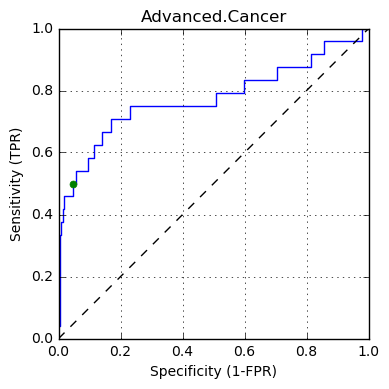

AUC = 0.7756792577866136
0.5 Sensitivity Probability Threshold = 0.10394196524343723
Confusion matrix:  [TN FP; FN, TP]
[[479  24]
 [ 13  11]]
----------------------------------
Advanced.Heart.Disease


,descr,weight
icd9,,
"(code, 420-429)",OTHER FORMS OF HEART DISEASE,0.005062
"(code, 410-414)",ISCHEMIC HEART DISEASE,0.003937
"(code, V45)",Other postprocedural states,0.002815
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.001645
"(code, 393-398)",CHRONIC RHEUMATIC HEART DISEASE,0.001249
"(code, 785)",Symptoms involving cardiovascular system,0.000874
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.000752
"(code, V58)",Encounter for other and unspecified procedures and aftercare,0.000590
"(code, V43)",Organ or tissue replaced by other means,0.000558


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Advanced.Heart.Disease_log_reg_roc.png


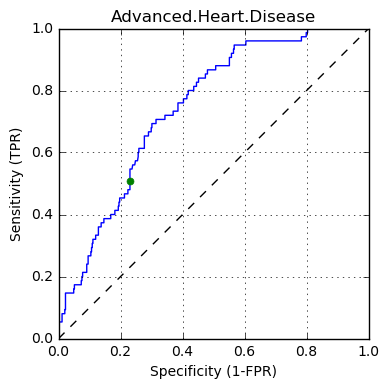

AUC = 0.7463864306784661
0.5 Sensitivity Probability Threshold = 0.1389763286339258
Confusion matrix:  [TN FP; FN, TP]
[[348 104]
 [ 38  37]]
----------------------------------
Advanced.Lung.Disease


,descr,weight
icd9,,
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",1.608568
"(code, 510-519)",OTHER DISEASES OF RESPIRATORY SYSTEM,1.206375
"(code, V46)",Other dependence on machines and devices,1.174741
"(code, 460-466)",ACUTE RESPIRATORY INFECTIONS,0.765785
"(code, 490-496)",CHRONIC OBSTRUCTIVE PULMONARY DISEASE AND ALLIED CONDITIONS,0.735720
"(code, 240-246)",DISORDERS OF THYROID GLAND,0.610108
"(code, 340-349)",OTHER DISORDERS OF THE CENTRAL NERVOUS SYSTEM,0.580053
"(code, V49)",Other conditions influencing health status,0.565586
"(code, V02)",Carrier or suspected carrier of infectious diseases,0.533711


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Advanced.Lung.Disease_log_reg_roc.png


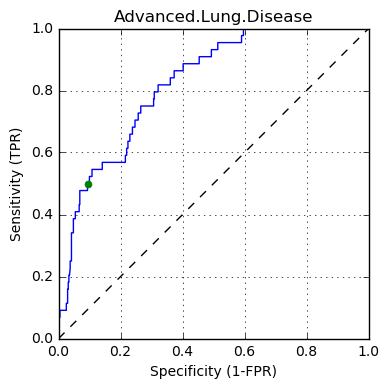

AUC = 0.8227696216826652
0.5 Sensitivity Probability Threshold = 0.19510015367599318
Confusion matrix:  [TN FP; FN, TP]
[[438  45]
 [ 23  21]]
----------------------------------
Alcohol.Abuse


,descr,weight
icd9,,
"(code, 570-579)",OTHER DISEASES OF DIGESTIVE SYSTEM,1.163718
"(code, 290-299)",PSYCHOSES,1.160067
"(code, V60)","Housing, household, and economic circumstances",1.134736
"(code, 789)",Other symptoms involving abdomen and pelvis,0.949451
"(code, 300-316)","NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS",0.786526
"(code, 070-079)",OTHER DISEASES DUE TO VIRUSES AND CHLAMYDIAE,0.775466
"(code, V08)",Asymptomatic human immunodeficiency virus [HIV] infection status,0.665920
"(code, V15)",Other personal history presenting hazards to health,0.638283
"(code, V11)",Personal history of mental disorder,0.594422


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Alcohol.Abuse_log_reg_roc.png


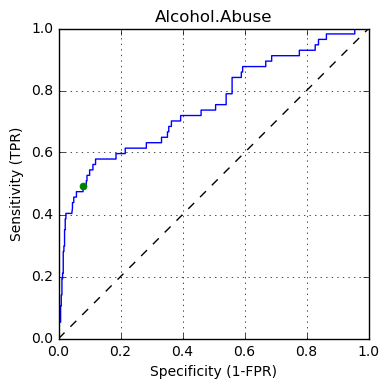

AUC = 0.7530608435983576
0.5 Sensitivity Probability Threshold = 0.15219003911941675
Confusion matrix:  [TN FP; FN, TP]
[[433  37]
 [ 30  27]]
----------------------------------
Chronic.Neurological.Dystrophies


,descr,weight
icd9,,
"(code, 340-349)",OTHER DISORDERS OF THE CENTRAL NERVOUS SYSTEM,0.002613
"(code, 590-599)",OTHER DISEASES OF URINARY SYSTEM,0.001986
"(code, 780)",General symptoms,0.001867
"(code, 330-337)",HEREDITARY AND DEGENERATIVE DISEASES OF THE CENTRAL NERVOUS SYSTEM,0.001600
"(code, 240-246)",DISORDERS OF THYROID GLAND,0.001534
"(code, 350-359)",DISORDERS OF THE PERIPHERAL NERVOUS SYSTEM,0.001523
"(code, 430-438)",CEREBROVASCULAR DISEASE,0.001221
"(code, 500-508)",PNEUMOCONIOSES AND OTHER LUNG DISEASES DUE TO EXTERNAL AGENTS,0.001212
"(code, 700-709)",OTHER DISEASES OF SKIN AND SUBCUTANEOUS TISSUE,0.001206


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Chronic.Neurological.Dystrophies_log_reg_roc.png


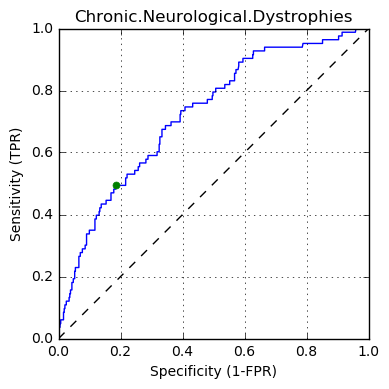

AUC = 0.7241262346684033
0.5 Sensitivity Probability Threshold = 0.14620750976262598
Confusion matrix:  [TN FP; FN, TP]
[[362  82]
 [ 43  40]]
----------------------------------
Chronic.Pain.Fibromyalgia


,descr,weight
icd9,,
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.001499
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",0.001358
"(code, 030-041)",OTHER BACTERIAL DISEASES,0.001335
"(code, V58)",Encounter for other and unspecified procedures and aftercare,0.001314
"(code, 725-729)","RHEUMATISM, EXCLUDING THE BACK",0.001144
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.001033
"(code, 590-599)",OTHER DISEASES OF URINARY SYSTEM,0.000974
"(code, 710-719)",ARTHROPATHIES AND RELATED DISORDERS,0.000923
"(code, 530-538)","DISEASES OF ESOPHAGUS, STOMACH, AND DUODENUM",0.000849


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Chronic.Pain.Fibromyalgia_log_reg_roc.png


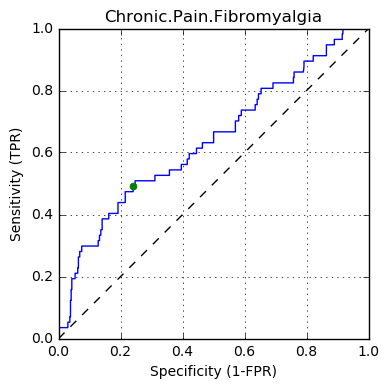

AUC = 0.6382045539380365
0.5 Sensitivity Probability Threshold = 0.10599105530911747
Confusion matrix:  [TN FP; FN, TP]
[[357 113]
 [ 30  27]]
----------------------------------
Dementia


,descr,weight
icd9,,
"(code, 290-299)",PSYCHOSES,0.002410
"(code, 330-337)",HEREDITARY AND DEGENERATIVE DISEASES OF THE CENTRAL NERVOUS SYSTEM,0.000984
"(code, 410-414)",ISCHEMIC HEART DISEASE,0.000682
"(code, V45)",Other postprocedural states,0.000663
"(code, 420-429)",OTHER FORMS OF HEART DISEASE,0.000591
"(code, 560-569)",OTHER DISEASES OF INTESTINES AND PERITONEUM,0.000511
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.000466
"(code, 590-599)",OTHER DISEASES OF URINARY SYSTEM,0.000463
"(code, 785)",Symptoms involving cardiovascular system,0.000449


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Dementia_log_reg_roc.png


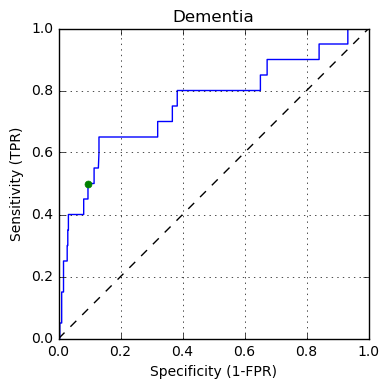

AUC = 0.757051282051282
0.5 Sensitivity Probability Threshold = 0.03856300219804359
Confusion matrix:  [TN FP; FN, TP]
[[459  48]
 [ 11   9]]
----------------------------------
Depression


,descr,weight
icd9,,
"(code, 300-316)","NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS",0.003354
"(code, 290-299)",PSYCHOSES,0.001928
"(code, 530-538)","DISEASES OF ESOPHAGUS, STOMACH, AND DUODENUM",0.001889
"(code, 070-079)",OTHER DISEASES DUE TO VIRUSES AND CHLAMYDIAE,0.001476
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.001269
"(code, 350-359)",DISORDERS OF THE PERIPHERAL NERVOUS SYSTEM,0.001053
"(code, V45)",Other postprocedural states,0.001042
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",0.000959
"(code, V60)","Housing, household, and economic circumstances",0.000855


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Depression_log_reg_roc.png


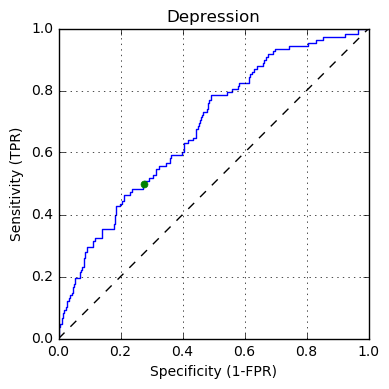

AUC = 0.6824449748077434
0.5 Sensitivity Probability Threshold = 0.16291146320902805
Confusion matrix:  [TN FP; FN, TP]
[[304 115]
 [ 55  53]]
----------------------------------
Developmental.Delay.Retardation


,descr,weight
icd9,,
"(code, 317-319)",MENTAL RETARDATION,4.468493
"(code, 150-159)",MALIGNANT NEOPLASM OF DIGESTIVE ORGANS AND PERITONEUM,1.593733
"(code, E939)",Psychotropic agents,1.532755
"(code, 500-508)",PNEUMOCONIOSES AND OTHER LUNG DISEASES DUE TO EXTERNAL AGENTS,1.451041
"(code, 480-488)",PNEUMONIA AND INFLUENZA,1.393855
"(code, 780)",General symptoms,1.289353
"(code, 290-299)",PSYCHOSES,1.198573
"(code, 240-246)",DISORDERS OF THYROID GLAND,1.193123
"(code, 690-698)",OTHER INFLAMMATORY CONDITIONS OF SKIN AND SUBCUTANEOUS TISSUE,1.041017


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Developmental.Delay.Retardation_log_reg_roc.png


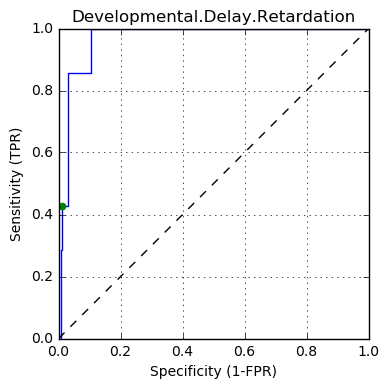

AUC = 0.968956043956044
0.5 Sensitivity Probability Threshold = 0.29711871330799156
Confusion matrix:  [TN FP; FN, TP]
[[515   5]
 [  5   2]]
----------------------------------
Non.Adherence


,descr,weight
icd9,,
"(code, 530-538)","DISEASES OF ESOPHAGUS, STOMACH, AND DUODENUM",0.001452
"(code, V15)",Other personal history presenting hazards to health,0.001374
"(code, 350-359)",DISORDERS OF THE PERIPHERAL NERVOUS SYSTEM,0.001329
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.001171
"(code, 360-379)",DISORDERS OF THE EYE AND ADNEXA,0.000959
"(code, 070-079)",OTHER DISEASES DUE TO VIRUSES AND CHLAMYDIAE,0.000900
"(code, V58)",Encounter for other and unspecified procedures and aftercare,0.000789
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.000754
"(code, 300-316)","NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS",0.000565


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Non.Adherence_log_reg_roc.png


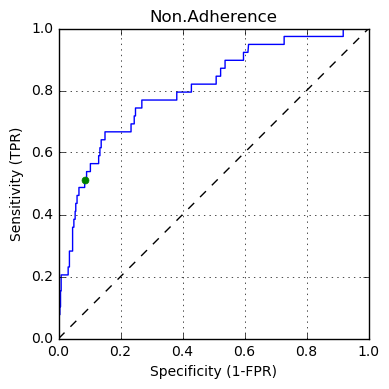

AUC = 0.8049337957124844
0.5 Sensitivity Probability Threshold = 0.07632155947215179
Confusion matrix:  [TN FP; FN, TP]
[[447  41]
 [ 20  19]]
----------------------------------
None


,descr,weight
icd9,,
"(code, V42)",Organ or tissue replaced by transplant,0.210770
"(code, 996-999)","COMPLICATIONS OF SURGICAL AND MEDICAL CARE, NOT ELSEWHERE CLASSIFIED",0.199843
"(code, 001-009)",INTESTINAL INFECTIOUS DISEASES,0.121922
"(code, 786)",Symptoms involving respiratory system and other chest symptoms,0.121564
"(code, 480-488)",PNEUMONIA AND INFLUENZA,0.110942
"(code, 440-449)","DISEASES OF ARTERIES, ARTERIOLES, AND CAPILLARIES",0.107852
"(code, 360-379)",DISORDERS OF THE EYE AND ADNEXA,0.104099
"(code, 420-429)",OTHER FORMS OF HEART DISEASE,0.100312
"(code, 788)",Symptoms involving urinary system,0.099602


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_None_log_reg_roc.png


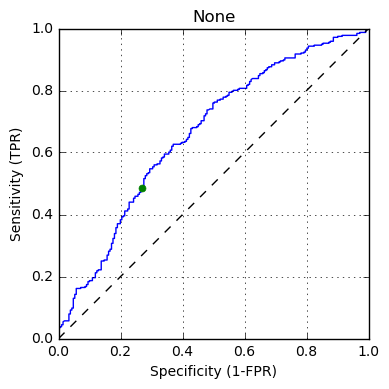

AUC = 0.6605450236966824
0.5 Sensitivity Probability Threshold = 0.6548677574348872
Confusion matrix:  [TN FP; FN, TP]
[[154  57]
 [164 152]]
----------------------------------
Obesity


,descr,weight
icd9,,
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.001250
"(code, 700-709)",OTHER DISEASES OF SKIN AND SUBCUTANEOUS TISSUE,0.001237
"(code, 510-519)",OTHER DISEASES OF RESPIRATORY SYSTEM,0.000885
"(code, 415-417)",DISEASES OF PULMONARY CIRCULATION,0.000885
"(code, 327)",ORGANIC SLEEP DISORDERS,0.000819
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.000713
"(code, 680-686)",INFECTIONS OF SKIN AND SUBCUTANEOUS TISSUE,0.000630
"(code, 780)",General symptoms,0.000586
"(code, V58)",Encounter for other and unspecified procedures and aftercare,0.000498


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Obesity_log_reg_roc.png


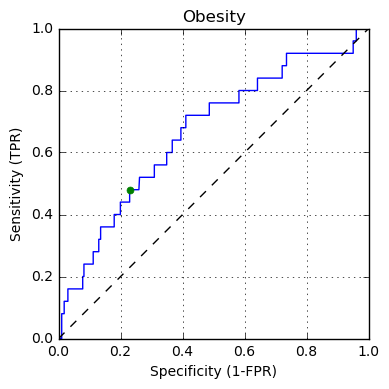

AUC = 0.6649800796812749
0.5 Sensitivity Probability Threshold = 0.04417569663751994
Confusion matrix:  [TN FP; FN, TP]
[[387 115]
 [ 14  11]]
----------------------------------
Other.Substance.Abuse


,descr,weight
icd9,,
"(code, 960-979)","POISONING BY DRUGS, MEDICINAL AND BIOLOGICAL SUBSTANCES",2.868189
"(code, 070-079)",OTHER DISEASES DUE TO VIRUSES AND CHLAMYDIAE,2.261325
"(code, V60)","Housing, household, and economic circumstances",2.162543
"(code, E939)",Psychotropic agents,1.824646
"(code, E888)",Other and unspecified fall,1.799809
"(code, E935)","Analgesics, antipyretics, and antirheumatics",1.577303
"(code, 110-118)",MYCOSES,1.473258
"(code, 300-316)","NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS",1.347367
"(code, E928)",Other and unspecified environmental and accidental causes,1.288913


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Other.Substance.Abuse_log_reg_roc.png


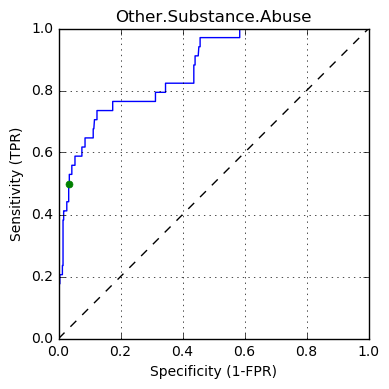

AUC = 0.8683927932227659
0.5 Sensitivity Probability Threshold = 0.33163980391797443
Confusion matrix:  [TN FP; FN, TP]
[[477  16]
 [ 18  16]]
----------------------------------
Schizophrenia.and.other.Psychiatric.Disorders


,descr,weight
icd9,,
"(code, 290-299)",PSYCHOSES,0.003059
"(code, 300-316)","NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS",0.002363
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",0.001407
"(code, 340-349)",OTHER DISORDERS OF THE CENTRAL NERVOUS SYSTEM,0.001083
"(code, 070-079)",OTHER DISEASES DUE TO VIRUSES AND CHLAMYDIAE,0.001064
"(code, 240-246)",DISORDERS OF THYROID GLAND,0.000945
"(code, V60)","Housing, household, and economic circumstances",0.000929
"(code, 030-041)",OTHER BACTERIAL DISEASES,0.000914
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.000852


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Schizophrenia.and.other.Psychiatric.Disorders_log_reg_roc.png


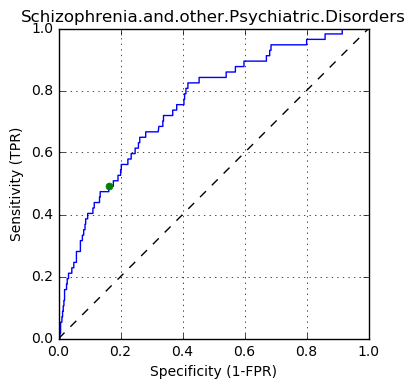

AUC = 0.7535087719298247
0.5 Sensitivity Probability Threshold = 0.11327678496224783
Confusion matrix:  [TN FP; FN, TP]
[[394  76]
 [ 30  27]]
----------------------------------
Unsure


,descr,weight
icd9,,
"(code, 420-429)",OTHER FORMS OF HEART DISEASE,0.001652
"(code, 270-279)",OTHER METABOLIC AND IMMUNITY DISORDERS,0.001351
"(code, 580-589)","NEPHRITIS, NEPHROTIC SYNDROME, AND NEPHROSIS",0.001012
"(code, V58)",Encounter for other and unspecified procedures and aftercare,0.000998
"(code, 730-739)","OSTEOPATHIES, CHONDROPATHIES, AND ACQUIRED MUSCULOSKELETAL DEFORMITIES",0.000880
"(code, 440-449)","DISEASES OF ARTERIES, ARTERIOLES, AND CAPILLARIES",0.000816
"(code, 790)",Nonspecific findings on examination of blood,0.000695
"(code, 393-398)",CHRONIC RHEUMATIC HEART DISEASE,0.000681
"(code, 780)",General symptoms,0.000679


Saving figure to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_Unsure_log_reg_roc.png


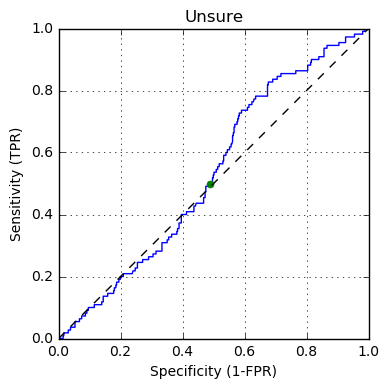

AUC = 0.5328101155439284
0.5 Sensitivity Probability Threshold = 0.18846364109275968
Confusion matrix:  [TN FP; FN, TP]
[[213 204]
 [ 56  54]]
----------------------------------


In [218]:
classifiers = {}
for cat in categories:
    print(cat)
    Y_test = fit_dat.loc[fit_dat['random'] < test_frac, cat].values
    Y_train = fit_dat.loc[fit_dat['random'] >= test_frac, cat].values    

    logreg = linear_model.LogisticRegressionCV() #class_weight={0: .05, 1: .95})
    logreg.fit(X_train, Y_train)    

    ranked_df = pd.DataFrame([{'icd9':i[0], 'weight': i[1]} for i in zip(feature_cols, logreg.coef_[0,:])]).\
      set_index('icd9')    
    ranked_df = code_lookup_df.join(ranked_df).sort_values('weight', ascending=False)
    display.display(ranked_df.head(10))

    Y_pred = logreg.predict_proba(X_test)[:, 1]
    
    [fpr, tpr, thresh] = metrics.roc_curve(Y_test, Y_pred)
    auc = metrics.auc(fpr, tpr)
    thresh_ind = np.abs(tpr-0.5).argmin()

    plt.plot(fpr, tpr)
    plt.plot(fpr[thresh_ind], tpr[thresh_ind], marker='.', markersize=10)
    plt.plot([0, 1],[0, 1],'k--')
    plt.grid(True)
    plt.axes().set_aspect('equal') 
    plt.title(cat)    
    plt.xlabel('Specificity (1-FPR)')
    plt.ylabel('Sensitivity (TPR)')

    fig_path = pl.Path(path_config['results_dir']).joinpath('{}_{}_log_reg_roc.png'.format(time_str, cat))
    print('Saving figure to {}'.format(fig_path))
    plt.savefig(fig_path.as_posix())
    
    plt.show()

    print('AUC = {}'.format(auc))
    print('0.5 Sensitivity Probability Threshold = {}'.format(thresh[thresh_ind]))    
    
    print('Confusion matrix:  [TN FP; FN, TP]')
    print(metrics.confusion_matrix(Y_test, Y_pred > thresh[thresh_ind]))
    print('----------------------------------')
    
    classifiers[cat] = {
        'classifier': logreg,
        'threshold': thresh[thresh_ind]
    }

In [202]:
list(path_config.keys())

['log_dir', 'input_dir', 'results_dir', 'repo_data_dir']

In [213]:
class_dat = {
    'classifiers': classifiers,
    'features': feature_cols
}
clf_path = pl.Path(path_config['results_dir']).joinpath('{}_icd9_log_reg.pkl'.format(time_str))
print('Saving classifiers to {}'.format(clf_path))
with open(clf_path.as_posix(), 'wb') as f:
    pkl.dump(class_dat, f)

Saving classifiers to /mnt/cbds_homes/ecarlson/results/mit_frequent_fliers/2016-10-24-20-30_icd9_log_reg.pkl
